<a href="https://colab.research.google.com/github/BYRic-F/E-commerce-Fraud-detection/blob/main/Vesta%20E-commerce_Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#import libraries for import files
from google.colab import files
import zipfile

#import libraries for Eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import libraries for stat
import scipy.stats as stats

In [2]:
#import and unzip dataset from Kaggle
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ieee-fraud-detection --force

with zipfile.ZipFile("ieee-fraud-detection.zip", "r") as zip_ref:
    zip_ref.extractall("ieee_fraud")



Saving kaggle.json to kaggle.json
 65% 77.0M/118M [00:00<00:00, 798MB/s]
100% 118M/118M [00:00<00:00, 345MB/s] 


In [50]:
# Function to test normality and select outlier detection method
def choose_outlier_method(data, col):
    # Verification of normality with the Shapiro-Wilk test
    sample = data[col].sample(n=5000, random_state=42)  # sample of 5000 values
    stat, p_value = stats.shapiro(sample)

    print(f"Shapiro-Wilk Test p-value: {p_value}")

    # If the p-value is less than 0.05, the data do not follow a normal distribution
    if p_value < 0.05:
        print(f"The distribution of {col} is not normal. Using IQR method.")
        # Use IQR method if data are not normal
        return outliers(data, col)
    else:
        print(f"The distribution of {col} is normal. Using 3 * std method.")
        # Use the 3 * std method if data follow a normal distribution
        return outliers_by_std(data, col)

# IQR outlier calculation function
def outliers(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    outliers = data[(data[col] > upper_bound) | (data[col] < lower_bound)]
    print(f"Number of outliers in {col}: {len(outliers)}")
    print(f"Number of lowest outliers in {col}: {len(outliers[outliers[col] < lower_bound])}")
    print(f"Number of highest outliers in {col}: {len(outliers[outliers[col] > upper_bound])}")
    print(f"Percentage of outliers in {col}: {len(outliers) / len(data) * 100:.2f}%")

# Function to calculate outliers with standard deviation
def outliers_by_std(data, col, std_factor=3):
    mean = data[col].mean()
    std_dev = data[col].std()
    upper_bound = mean + std_factor * std_dev
    lower_bound = mean - std_factor * std_dev
    outliers = data[(data[col] > upper_bound) | (data[col] < lower_bound)]
    print(f"Number of outliers in {col} using {std_factor} std: {len(outliers)}")
    print(f"Number of lowest outliers in {col} using {std_factor} std: {len(outliers[outliers[col] < lower_bound])}")
    print(f"Number of highest outliers in {col} using {std_factor} std: {len(outliers[outliers[col] > upper_bound])}")
    print(f"Percentage of outliers in {col} using {std_factor} std: {len(outliers) / len(data) * 100:.2f}%")



In [3]:
# Load dataset transaction

train_transaction = pd.read_csv("ieee_fraud/train_transaction.csv")
test_transaction = pd.read_csv("ieee_fraud/test_transaction.csv")

train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Load dataset identity

train_identity = pd.read_csv("ieee_fraud/train_identity.csv")
test_identity = pd.read_csv("ieee_fraud/test_identity.csv")

train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_identity.shape

(144233, 41)

In [6]:
train_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [7]:
train_transaction.shape

(590540, 394)

In [8]:
train_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

I want to merge the 2 datasets. However, we don't have the same number of lines.

On closer inspection, we notice that some TransactionID are missing from the train_identity dataset. So we'll have to do a left merge to avoid losing any data.

In [9]:
# Merge the two datasets using a left merge on 'TransactionID'
train= pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train.head()

test= pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

I Check if I have all rows

In [10]:
print(f"Before merge on train : {train_transaction.shape[0]} transactions")
print(f"After merge on train : {train.shape[0]} transactions")


print(f"Before merge on test : {test_transaction.shape[0]} transactions")
print(f"After merge on test : {test.shape[0]} transactions")


del train_transaction, train_identity, test_transaction, test_identity





Before merge on train : 590540 transactions
After merge on train : 590540 transactions
Before merge on test : 506691 transactions
After merge on test : 506691 transactions


# I) <u> EDA </u>

We'll now explore the dataset.

We have a dataset that identifies fraudulent transactions according to various criteria.
The main difficulty is that the data has been anonymized.
After various searches, I was able to find out what the different columns correspond to.
My main source was https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/101203.

#### <u> Transaction Table </u>
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

- TransactionAMT: transaction payment amount in USD

- ProductCD: product code, the product for each transaction

- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

- addr: address, addr1 as billing region and addr2 as billing country

- dist: distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.

- P_ and (R__) emaildomain: purchaser and recipient email domain

- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

- D1-D15: timedelta, such as days between previous transaction, etc.

- M1-M9: match, such as names on card and address, etc.

- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

##### <u>Categorical Features </u>
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

#### <u>Identity Table</u>

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

##### <u>Categorical Features </u>
- DeviceType
- DeviceInfo
- id_12 - id_38


I notice a large amount of NaN in the dataset.
We'll start by analyzing the missing values.

#### a) Missing Values

In [11]:
missing_values = train.isnull().mean() * 100  # In percent
missing_values = missing_values[missing_values > 0] #  We keep only missing values
missing_values.sort_values(ascending=False)

,0
id_24,99.196159
id_25,99.130965
id_07,99.127070
id_08,99.127070
id_21,99.126393
...,...
V309,0.002032
V312,0.002032
V311,0.002032
V310,0.002032


Some columns contain many missing values.

Now I'm going to look at the proportion of fraud on the dataset.

#### b) Is Fraud?

3.5 % of transactions are fraudulent


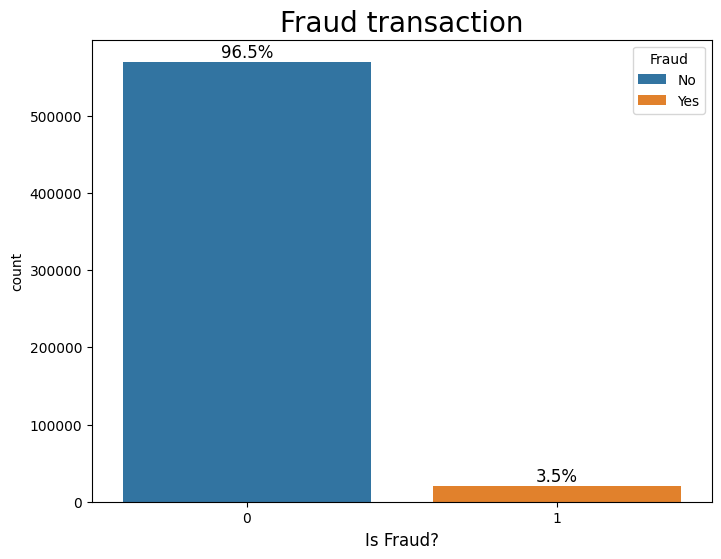

In [12]:
#Percentage of frauds

percentage_frauds = train['isFraud'].value_counts(normalize=True)*100

print(percentage_frauds[1].round(2),'% of transactions are fraudulent')

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=train, x='isFraud', hue= 'isFraud')
plt.title("Fraud transaction", fontsize='20')
plt.xlabel("Is Fraud?", fontsize=12)
plt.legend(title="Fraud", labels=["No", "Yes"])


total = len(train)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
      percentage = f'{100 * height / total:.1f}%'
      # Adjust vertical position of annotation
      ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2, height + 1000),  # Add vertical offset
                ha='center', va='bottom', fontsize=12, color='black')

plt.show()

We have 3.5% of Fraud transactions in our dataset.

Now, we'll explore the transaction amount.

#### c) Transaction amounts


In [13]:
print(train.groupby("isFraud")["TransactionAmt"].describe())

            count        mean         std    min     25%   50%    75%  \
isFraud                                                                 
0        569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1         20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

               max  
isFraud             
0        31937.391  
1         5191.000  


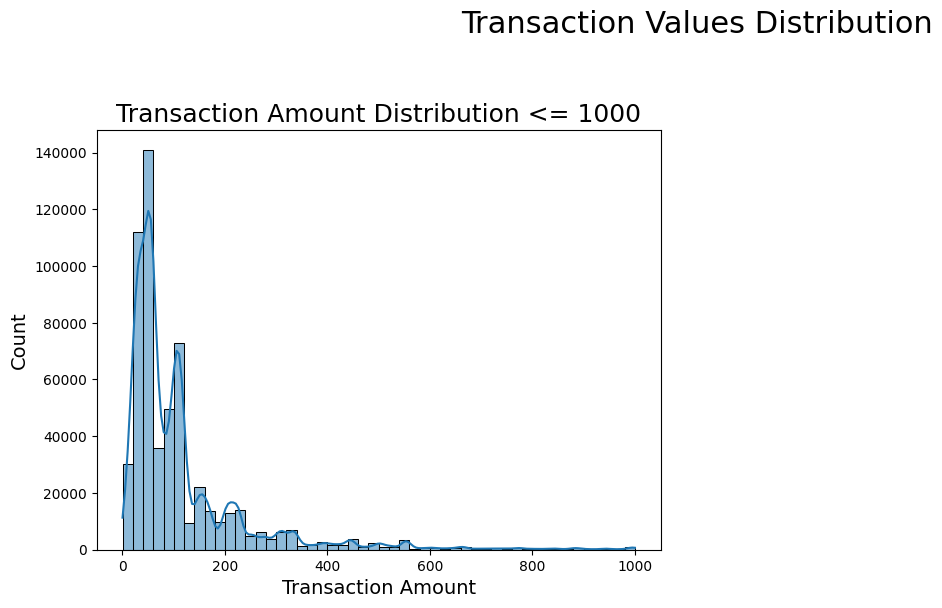

In [14]:
plt.figure(figsize=(16, 12))
plt.suptitle('Transaction Values Distribution', fontsize=22)

# Add a subgraph for transaction amounts <= 1000
plt.subplot(221)
g = sns.histplot(train[train['TransactionAmt'] <= 1000]['TransactionAmt'], kde=True, bins=50,)

g.set_title("Transaction Amount Distribution <= 1000", fontsize=18)
g.set_xlabel("Transaction Amount", fontsize=14)
g.set_ylabel("Count", fontsize=14)


plt.show()

The dataset mainly concerns small amounts (>$300).

I'm now going to see if the same applies to fraudulent amounts.

<ipython-input-15-5fd6b8458c0f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="coolwarm")


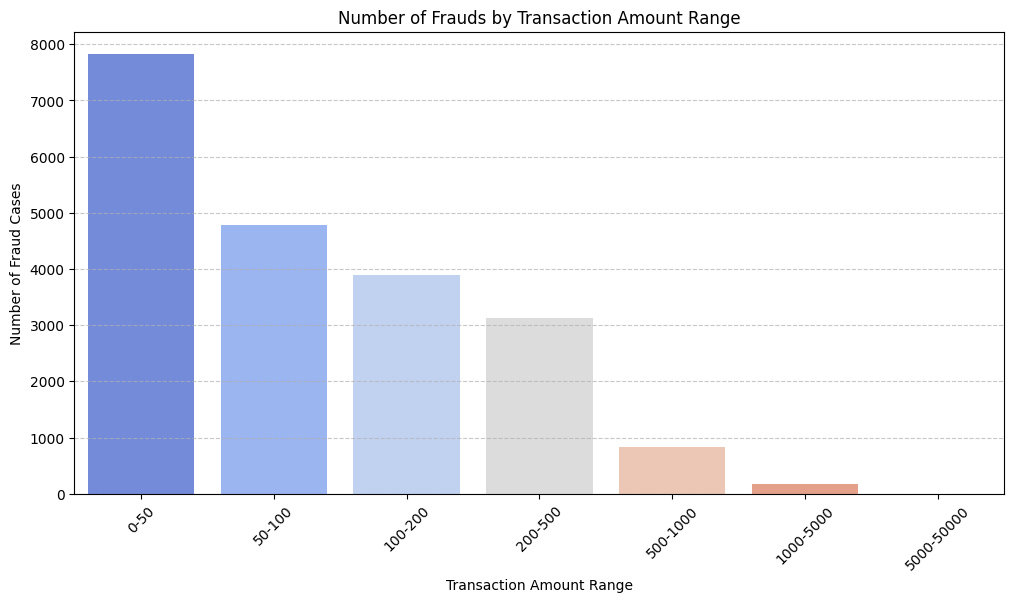

In [15]:
# Define larger amount brackets
bins = [0, 50, 100, 200, 500, 1000, 5000, 50000]
labels = ["0-50", "50-100", "100-200", "200-500", "500-1000", "1000-5000", "5000-50000"]

# Create a new column with slices
train["Amount_bins"] = pd.cut(train["TransactionAmt"], bins=bins, labels=labels, include_lowest=True)

# Count the number of frauds in each bins
fraud_counts = train[train["isFraud"] == 1]["Amount_bins"].value_counts().sort_index()

# Trace
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="coolwarm")
plt.xlabel("Transaction Amount Range")
plt.ylabel("Number of Fraud Cases")
plt.title("Number of Frauds by Transaction Amount Range")
plt.xticks(rotation=45)  # Rotation pour améliorer la lisibilité
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


We see the same kind of representation.

To support our assertion, let's calculate the proportion of fraud according to each bin.

<ipython-input-59-e7e554f2f87b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_transactions = train.groupby("Amount_bins").size()
<ipython-input-59-e7e554f2f87b>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_transactions = train[train["isFraud"] == 1].groupby("Amount_bins").size()
<ipython-input-59-e7e554f2f87b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_proportion.index, y=fraud_proportion.values, palette="coolwarm")


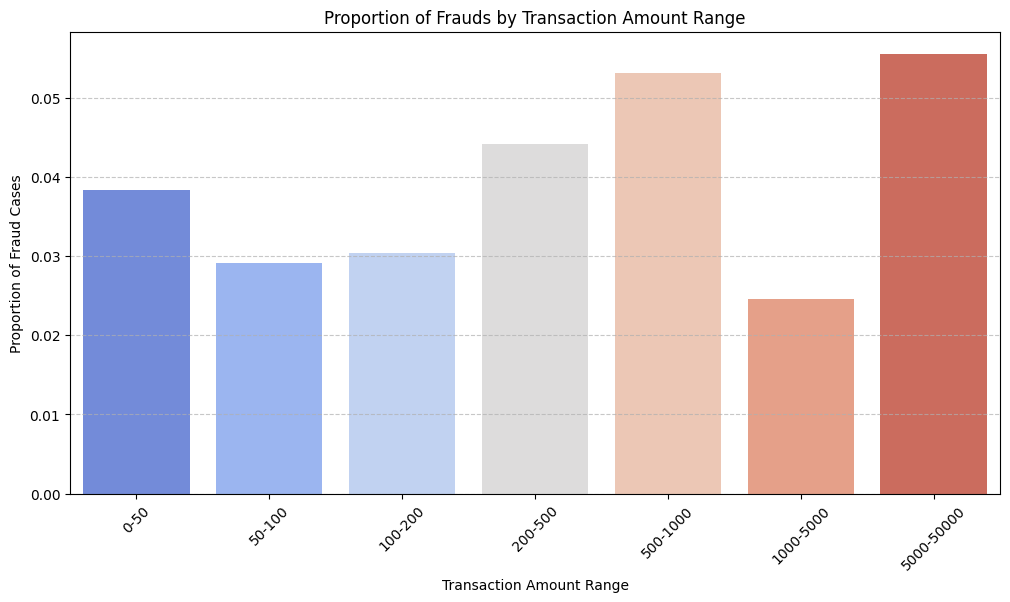

In [59]:
# Calculate the total number of transactions and the number of frauds per bracket
total_transactions = train.groupby("Amount_bins").size()
fraud_transactions = train[train["isFraud"] == 1].groupby("Amount_bins").size()

# Calculate the proportion of fraud
fraud_proportion = (fraud_transactions / total_transactions).fillna(0)

# Trace
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_proportion.index, y=fraud_proportion.values, palette="coolwarm")
plt.xlabel("Transaction Amount Range")
plt.ylabel("Proportion of Fraud Cases")
plt.title("Proportion of Frauds by Transaction Amount Range")
plt.xticks(rotation=45)  # Rotation pour améliorer la lisibilité
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

There is no over-representation, but the percentage is slightly higher for higher amounts.

In [53]:
print(choose_outlier_method(train, 'TransactionAmt'))

Shapiro-Wilk Test p-value: 1.7180819714484917e-81
The distribution of TransactionAmt is not normal. Using IQR method.
Number of outliers in TransactionAmt: 66482
Number of lowest outliers in TransactionAmt: 0
Number of highest outliers in TransactionAmt: 66482
Percentage of outliers in TransactionAmt: 11.26%
None


There are no lowest outliers on the datatest.

10% outliers is quite significant and requires further analysis.
We'll come back to this after analyzing the other columns.

Now we'll work on the ProductCD column.

#### d) ProductCD


Product Distribution:
ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64


<ipython-input-64-f74f5bbaefbd>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ProductCD', data=data, palette='coolwarm')


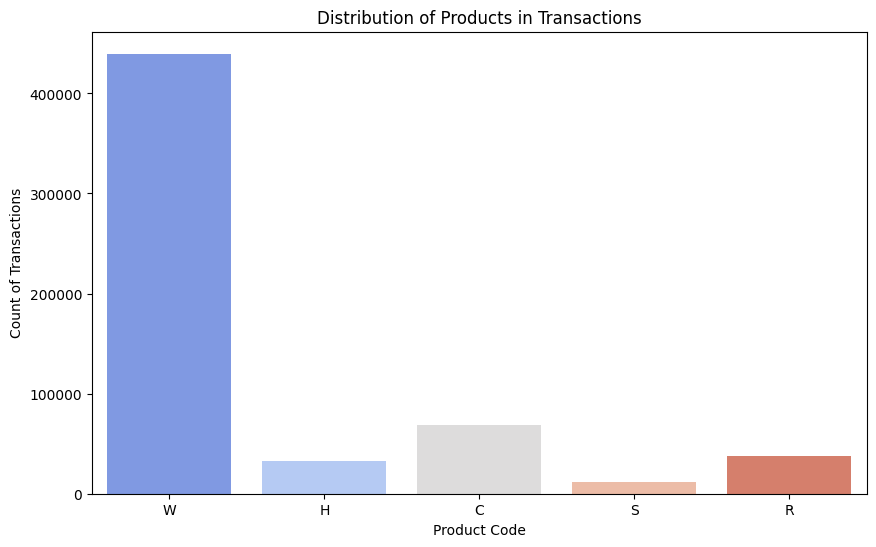

Fraud Distribution by ProductCD:
ProductCD
W    8969
C    8008
H    1574
R    1426
S     686
Name: count, dtype: int64


<ipython-input-64-f74f5bbaefbd>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ProductCD', data=data[data['isFraud'] == 1], palette='coolwarm')


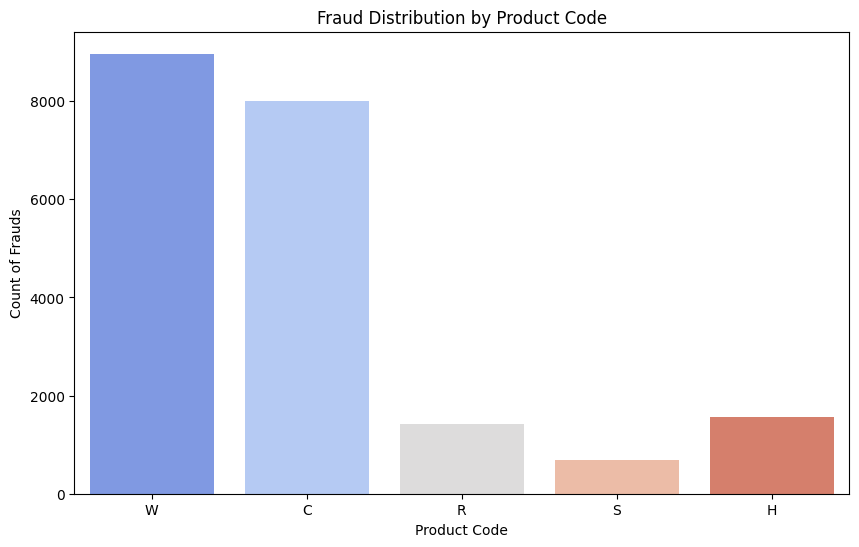

Fraud Percentage by Product Code:
ProductCD
C    11.687269
H     4.766231
R     3.782594
S     5.899553
W     2.039939
Name: count, dtype: float64


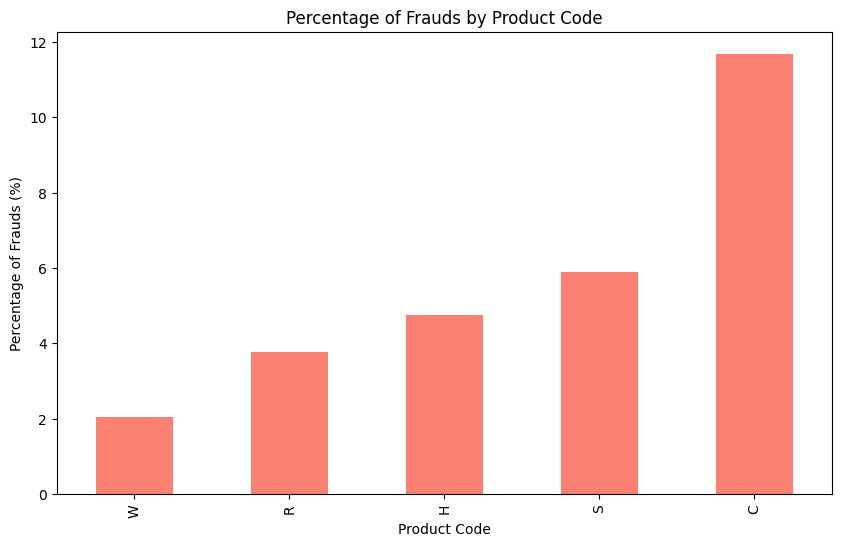

In [64]:
# Product distribution analysis
def product_distribution(data):
    product_counts = data['ProductCD'].value_counts()
    print("Product Distribution:")
    print(product_counts)

    # Visualize
    plt.figure(figsize=(10, 6))
    sns.countplot(x='ProductCD', data=data, palette='coolwarm')
    plt.title("Distribution of Products in Transactions")
    plt.xlabel("Product Code")
    plt.ylabel("Count of Transactions")
    plt.show()

# Analysis of fraud distribution by product
def fraud_by_product(data):
    fraud_counts = data[data['isFraud'] == 1]['ProductCD'].value_counts()
    print("Fraud Distribution by ProductCD:")
    print(fraud_counts)

    # Visalize
    plt.figure(figsize=(10, 6))
    sns.countplot(x='ProductCD', data=data[data['isFraud'] == 1], palette='coolwarm')
    plt.title("Fraud Distribution by Product Code")
    plt.xlabel("Product Code")
    plt.ylabel("Count of Frauds")
    plt.show()

# Percentage of fraud by product
def fraud_percentage_by_product(data):
    # Total number of transactions
    total_transactions = len(data)

    # Transactions by product
    transactions_by_product = data['ProductCD'].value_counts()

    # Number of frauds by product
    frauds_by_product = data[data['isFraud'] == 1]['ProductCD'].value_counts()

    # Percentage
    fraud_percentage = (frauds_by_product / transactions_by_product) * 100
    print("Fraud Percentage by Product Code:")
    print(fraud_percentage)

    # Visualize
    plt.figure(figsize=(10, 6))
    fraud_percentage.sort_values().plot(kind='bar', color='salmon')
    plt.title("Percentage of Frauds by Product Code")
    plt.xlabel("Product Code")
    plt.ylabel("Percentage of Frauds (%)")
    plt.show()


product_distribution(train)
fraud_by_product(train)
fraud_percentage_by_product(train)


The most represented product is W. Logically, it is also the most fraudulent.
We note that C has a lot of frauds, even though it has a fairly low representation in the dataset.

In fact, 11% of C transactions are fraudulent, well above the average of 3.5% calculated earlier.

We can therefore confirm that a transaction involving a C product carries a higher risk of fraud.